# Modelling Suara Buka Tutup & Deployment

## 1: Import Libraries & Load Data
Mengimpor library machine learning dan memuat data training/validation yang sudah diproses dari file numpy.


In [7]:
### 1. Import & Load Data Fitur
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from IPython.display import display

# Load dataset dengan fitur terpilih / clean
train_df = pd.read_csv("train_features_clean.csv")
val_df   = pd.read_csv("val_features_clean.csv")

# Pastikan kolom label ada
if 'label' not in train_df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan di train_features_clean.csv")
if 'label' not in val_df.columns:
    raise ValueError("Kolom 'label' tidak ditemukan di val_features_clean.csv")

# Hitung jumlah fitur terpilih (exclude kolom 'label')
n_features = train_df.shape[1] - 1

print(f"Data Train: {train_df.shape}, Data Val: {val_df.shape}")
print(f"Menggunakan {n_features} fitur terpilih")

# Tampilkan 5 baris pertama sebagai sanity check
display(train_df.head())


Data Train: (156, 8), Data Val: (38, 8)
Menggunakan 7 fitur terpilih


,mfcc_11_std,mfcc_2_std,mfcc_9_mean,mfcc_1_mean,mfcc_5_std,mfcc_4_std,mfcc_10_std,label
0,4.126870,6.403181,11.847911,76.095424,3.430487,5.272903,8.416341,asep_tutup
1,4.807991,13.758578,-2.062168,105.079752,11.652498,18.917321,20.818237,yotan_tutup
2,5.816457,24.703270,-5.700242,104.916755,13.649834,13.019024,21.494608,yotan_tutup
3,6.185442,5.677771,10.125528,71.563824,6.699243,5.812714,8.203546,asep_tutup
4,5.246340,14.044587,-9.555112,62.291460,15.033220,13.679497,19.749713,yotan_tutup


In [10]:
# Cell: Pastikan kolom label_jenis & label_speaker ada, lalu pisahkan X & y untuk dua target
import pandas as pd
from IPython.display import display

# reload (opsional) jika ingin memastikan terbaru
train_df = pd.read_csv("train_features_clean.csv")
val_df   = pd.read_csv("val_features_clean.csv")

print("Kolom di train_df:", train_df.columns.tolist()[:20])
print("Kolom di val_df  :", val_df.columns.tolist()[:20])

# Helper: buat kolom label_speaker & label_jenis bila belum ada
def ensure_label_columns(df):
    # jika sudah ada, lewati
    if 'label_speaker' in df.columns and 'label_jenis' in df.columns:
        return df

    # jika ada kolom 'speaker' dan 'action', gunakan itu
    if 'speaker' in df.columns and 'action' in df.columns:
        df['label_speaker'] = df['speaker']
        df['label_jenis'] = df['action']
        return df

    # jika ada kolom 'label' (combined), coba split dengan delimiter '_'
    if 'label' in df.columns:
        # cek pola: apakah ada underscore?
        sample = df['label'].dropna().astype(str)
        if sample.str.contains('_').any():
            # split into two parts at first underscore
            parts = sample.iloc[0].split('_')
            if len(parts) >= 2:
                # apply safe split for all rows
                df[['label_speaker', 'label_jenis']] = df['label'].astype(str).str.split('_', n=1, expand=True)
                return df
        # jika label hanya 'buka'/'tutup' atau hanya speaker, buat kolom sesuai (fallback)
        unique_vals = sample.unique()
        if set(unique_vals).issubset({'buka','tutup'}):
            df['label_jenis'] = df['label']
            df['label_speaker'] = None
            return df
        # jika values domain terlihat speaker-like (mis. asep,yotan)
        # coba deteksi speaker dari values containing alphabet letters and not buka/tutup
        possible_speakers = [v for v in unique_vals if v not in ('buka','tutup')][:5]
        if len(possible_speakers) > 0:
            # fallback: set label_speaker = label, leave label_jenis None
            df['label_speaker'] = df['label']
            df['label_jenis'] = None
            return df

    # terakhir: tidak ada info, buat kolom kosong
    df['label_speaker'] = None
    df['label_jenis'] = None
    return df

train_df = ensure_label_columns(train_df)
val_df   = ensure_label_columns(val_df)

# Tampilkan unique values untuk konfirmasi
print("\nUnique labels (train):")
print("  combined label (sample):", train_df['label'].dropna().unique()[:5])
print("  label_speaker unique:", pd.Series(train_df['label_speaker'].fillna('None')).unique())
print("  label_jenis   unique:", pd.Series(train_df['label_jenis'].fillna('None')).unique())

print("\nUnique labels (val):")
print("  combined label (sample):", val_df['label'].dropna().unique()[:5])
print("  label_speaker unique:", pd.Series(val_df['label_speaker'].fillna('None')).unique())
print("  label_jenis   unique:", pd.Series(val_df['label_jenis'].fillna('None')).unique())

# Jika ada None pada label_jenis atau label_speaker, beri peringatan
if train_df['label_jenis'].isnull().any() or val_df['label_jenis'].isnull().any():
    print("\n⚠️ Warning: Ada baris tanpa label_jenis (buka/tutup). Pastikan label tersedia untuk semua sample jika ingin melatih model jenis suara.")
if train_df['label_speaker'].isnull().any() or val_df['label_speaker'].isnull().any():
    print("⚠️ Warning: Ada baris tanpa label_speaker. Pastikan label speaker tersedia jika ingin melatih model speaker identification.")

# Sekarang pisahkan X & y untuk dua target
# Pilih fitur: semua kolom kecuali metadata kolom berikut
meta_cols = ['label', 'label_speaker', 'label_jenis', 'speaker', 'action', 'filename']
feature_cols = [c for c in train_df.columns if c not in meta_cols]

print(f"\nMenggunakan {len(feature_cols)} kolom fitur.")

X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()

# Label untuk task 1: buka/tutup
y_train_jenis = train_df['label_jenis'].astype(str)
y_val_jenis   = val_df['label_jenis'].astype(str)

# Label untuk task 2: speaker
y_train_speaker = train_df['label_speaker'].astype(str)
y_val_speaker   = val_df['label_speaker'].astype(str)

print("\nShapes:")
print("  X_train:", X_train.shape, "y_train_jenis:", y_train_jenis.shape, "y_train_speaker:", y_train_speaker.shape)
print("  X_val  :", X_val.shape,   "y_val_jenis  :", y_val_jenis.shape,   "y_val_speaker  :", y_val_speaker.shape)

# show top rows for sanity
print("\nContoh baris fitur (X_train) dan label:")
display(X_train.head())
display(pd.DataFrame({'label_speaker': y_train_speaker.head(), 'label_jenis': y_train_jenis.head()}))


Kolom di train_df: ['mfcc_11_std', 'mfcc_2_std', 'mfcc_9_mean', 'mfcc_1_mean', 'mfcc_5_std', 'mfcc_4_std', 'mfcc_10_std', 'label']
Kolom di val_df  : ['mfcc_11_std', 'mfcc_2_std', 'mfcc_9_mean', 'mfcc_1_mean', 'mfcc_5_std', 'mfcc_4_std', 'mfcc_10_std', 'label']

Unique labels (train):
  combined label (sample): ['asep_tutup' 'yotan_tutup' 'asep_buka' 'yotan_buka']
  label_speaker unique: ['asep' 'yotan']
  label_jenis   unique: ['tutup' 'buka']

Unique labels (val):
  combined label (sample): ['asep_buka' 'yotan_buka' 'asep_tutup' 'yotan_tutup']
  label_speaker unique: ['asep' 'yotan']
  label_jenis   unique: ['buka' 'tutup']

Menggunakan 7 kolom fitur.

Shapes:
  X_train: (156, 7) y_train_jenis: (156,) y_train_speaker: (156,)
  X_val  : (38, 7) y_val_jenis  : (38,) y_val_speaker  : (38,)

Contoh baris fitur (X_train) dan label:


,mfcc_11_std,mfcc_2_std,mfcc_9_mean,mfcc_1_mean,mfcc_5_std,mfcc_4_std,mfcc_10_std
0,4.126870,6.403181,11.847911,76.095424,3.430487,5.272903,8.416341
1,4.807991,13.758578,-2.062168,105.079752,11.652498,18.917321,20.818237
2,5.816457,24.703270,-5.700242,104.916755,13.649834,13.019024,21.494608
3,6.185442,5.677771,10.125528,71.563824,6.699243,5.812714,8.203546
4,5.246340,14.044587,-9.555112,62.291460,15.033220,13.679497,19.749713


,label_speaker,label_jenis
0,asep,tutup
1,yotan,tutup
2,yotan,tutup
3,asep,tutup
4,yotan,tutup


PISAHKAN LABEL

In [11]:
meta_cols = ['label', 'label_jenis', 'label_speaker', 'speaker', 'action', 'filename']
feature_cols = [c for c in train_df.columns if c not in meta_cols]

# Fitur
X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()

# Label 1: buka / tutup
y_train_jenis = train_df['label_jenis'].copy()
y_val_jenis   = val_df['label_jenis'].copy()

# Label 2: speaker (asep / yotan / dst)
y_train_speaker = train_df['label_speaker'].copy()
y_val_speaker   = val_df['label_speaker'].copy()

# Print shapes & a quick preview (sanity check)
print("\nShapes:")
print("  X_train:", X_train.shape, "y_train_jenis:", y_train_jenis.shape, "y_train_speaker:", y_train_speaker.shape)
print("  X_val  :", X_val.shape,   "y_val_jenis  :", y_val_jenis.shape,   "y_val_speaker  :", y_val_speaker.shape)

print("\nContoh label (first 5):")
display(pd.DataFrame({'label_speaker': y_train_speaker.head(), 'label_jenis': y_train_jenis.head()}))


Shapes:
  X_train: (156, 7) y_train_jenis: (156,) y_train_speaker: (156,)
  X_val  : (38, 7) y_val_jenis  : (38,) y_val_speaker  : (38,)

Contoh label (first 5):


,label_speaker,label_jenis
0,asep,tutup
1,yotan,tutup
2,yotan,tutup
3,asep,tutup
4,yotan,tutup


MEMBUAT MODEL LATIH RANDOM FOREST

In [12]:
from sklearn.ensemble import RandomForestClassifier

# --- Model 1: Prediksi Jenis (Buka/Tutup) ---
rf_jenis = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_jenis.fit(X_train, y_train_jenis)
print("✅ Random Forest untuk prediksi jenis (buka/tutup) selesai dilatih.")

# --- Model 2: Prediksi Speaker ---
rf_speaker = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_speaker.fit(X_train, y_train_speaker)
print("✅ Random Forest untuk prediksi speaker selesai dilatih.")


✅ Random Forest untuk prediksi jenis (buka/tutup) selesai dilatih.
✅ Random Forest untuk prediksi speaker selesai dilatih.


evaluasi model data validation

Akurasi Model Random Forest (Buka/Tutup): 84.21%

=== Classification Report (Buka/Tutup) ===
              precision    recall  f1-score   support

        buka       0.80      0.89      0.84        18
       tutup       0.89      0.80      0.84        20

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.85      0.84      0.84        38



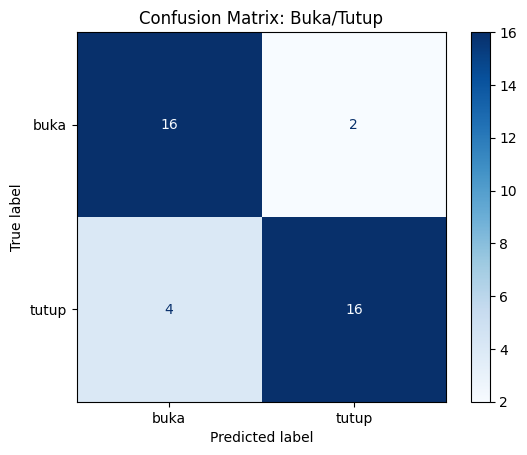

Akurasi Model Random Forest (Speaker): 94.74%

=== Classification Report (Speaker) ===
              precision    recall  f1-score   support

        asep       0.91      1.00      0.95        20
       yotan       1.00      0.89      0.94        18

    accuracy                           0.95        38
   macro avg       0.95      0.94      0.95        38
weighted avg       0.95      0.95      0.95        38



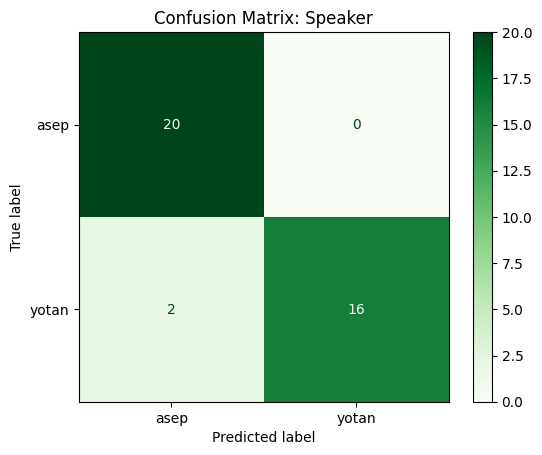

['model_results/rf_model_speaker.pkl']

In [13]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib
import matplotlib.pyplot as plt

# --- Prediksi dan evaluasi untuk Jenis (Buka/Tutup) ---
y_pred_jenis = rf_jenis.predict(X_val)
acc_jenis = accuracy_score(y_val_jenis, y_pred_jenis)
print(f"Akurasi Model Random Forest (Buka/Tutup): {acc_jenis*100:.2f}%\n")
print("=== Classification Report (Buka/Tutup) ===")
print(classification_report(y_val_jenis, y_pred_jenis))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val_jenis, y_pred_jenis, cmap='Blues')
plt.title("Confusion Matrix: Buka/Tutup")
plt.show()

# Simpan model
joblib.dump(rf_jenis, 'model_results/rf_model_buka_tutup.pkl')

# --- Prediksi dan evaluasi untuk Speaker ---
y_pred_speaker = rf_speaker.predict(X_val)
acc_speaker = accuracy_score(y_val_speaker, y_pred_speaker)
print(f"Akurasi Model Random Forest (Speaker): {acc_speaker*100:.2f}%\n")
print("=== Classification Report (Speaker) ===")
print(classification_report(y_val_speaker, y_pred_speaker))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val_speaker, y_pred_speaker, cmap='Greens')
plt.title("Confusion Matrix: Speaker")
plt.show()

# Simpan model
joblib.dump(rf_speaker, 'model_results/rf_model_speaker.pkl')


confusion matrix

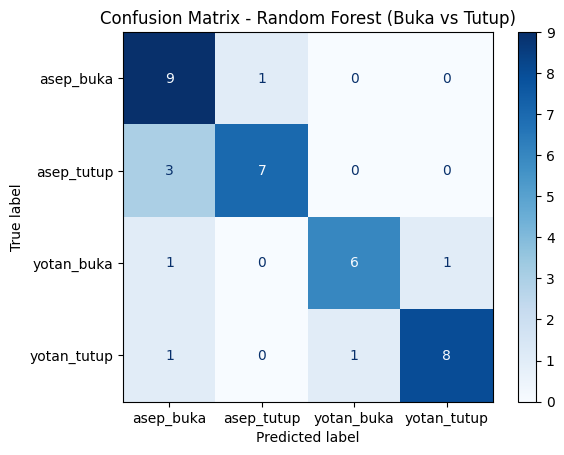

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Buka vs Tutup)")
plt.show()

fitur importance

/tmp/ipykernel_36828/636651628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_jenis, y=importances_jenis.index, palette='mako')


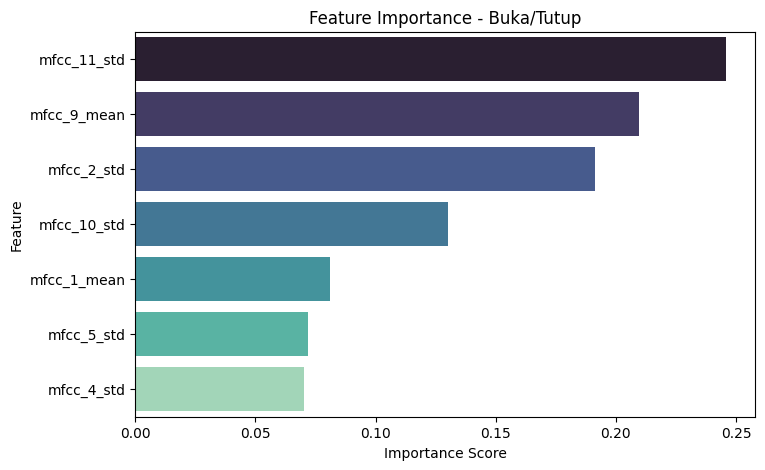

/tmp/ipykernel_36828/636651628.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_speaker, y=importances_speaker.index, palette='viridis')


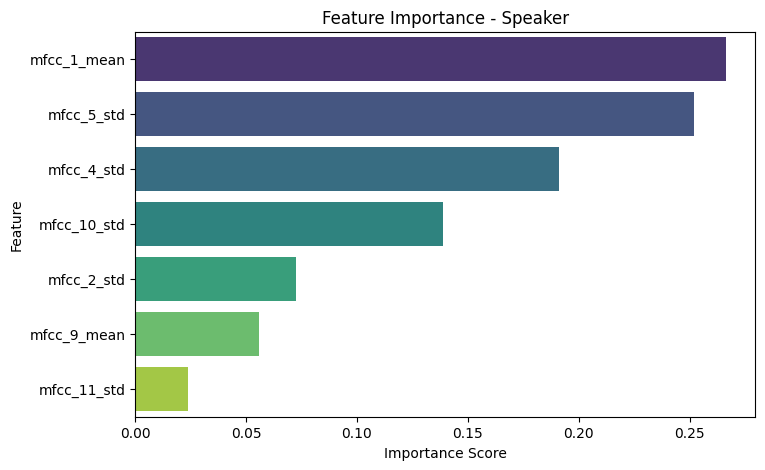

In [15]:
# Feature importance untuk Buka/Tutup
importances_jenis = pd.Series(rf_jenis.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances_jenis, y=importances_jenis.index, palette='mako')
plt.title("Feature Importance - Buka/Tutup")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Feature importance untuk Speaker
importances_speaker = pd.Series(rf_speaker.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances_speaker, y=importances_speaker.index, palette='viridis')
plt.title("Feature Importance - Speaker")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [17]:
import os
import librosa
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

def extract_enhanced_speaker_features(y, sr=22050):
    """Ekstraksi fitur speaker dari audio"""
    # 1. MFCC features (13 coefficients)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_std = np.std(mfccs, axis=1)
    
    # 2. Pitch/Fundamental frequency
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
    
    # 3. Spectral features
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zero_crossing = librosa.feature.zero_crossing_rate(y)
    
    # 4. Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Gabungkan semua fitur
    features = np.concatenate([
        mfcc_mean, mfcc_std,
        [pitch_mean],
        [np.mean(spectral_centroids)],
        [np.mean(spectral_rolloff)],
        [np.mean(zero_crossing)],
        chroma_mean
    ])
    return features

def preprocess_audio_for_speaker(y, sr, target_sr=22050):
    """Preprocessing audio: resample, durasi 2 detik, normalisasi, noise reduction"""
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    
    max_len = int(sr * 2.0)  # 2 detik
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)), mode='constant')
    else:
        start = (len(y) - max_len) // 2
        y = y[start:start+max_len]
    
    y = y / (np.max(np.abs(y)) + 1e-6)
    y[np.abs(y) < 0.005] = 0.0
    return y, sr

def build_speaker_dataset(speaker_dir="speaker_samples"):
    """
    Membuat dataset speaker otomatis:
    - Ekstrak fitur tiap file audio
    - Tambahkan label speaker
    - Return DataFrame
    """
    data = []
    labels = []
    
    for speaker_name in os.listdir(speaker_dir):
        speaker_path = os.path.join(speaker_dir, speaker_name)
        if not os.path.isdir(speaker_path):
            continue
        
        print(f"\nProcessing speaker: {speaker_name}")
        
        for audio_file in os.listdir(speaker_path):
            if audio_file.endswith('.wav'):
                audio_path = os.path.join(speaker_path, audio_file)
                try:
                    y, sr = librosa.load(audio_path, sr=22050)
                    y_proc, sr_proc = preprocess_audio_for_speaker(y, sr)
                    features = extract_enhanced_speaker_features(y_proc, sr_proc)
                    features_norm = features / (np.linalg.norm(features) + 1e-8)
                    
                    data.append(features_norm)
                    labels.append(speaker_name)
                    print(f"  Processed: {audio_file} -> {len(features)} features")
                except Exception as e:
                    print(f"  Error processing {audio_file}: {e}")
    
    df = pd.DataFrame(data)
    df['label_speaker'] = labels
    print(f"\nDataset speaker siap: {df.shape[0]} samples, {df.shape[1]-1} fitur + label")
    return df

if __name__ == "__main__":
    speaker_df = build_speaker_dataset("speaker_samples")
    speaker_df.to_csv("speaker_dataset.csv", index=False)
    print("\nDataset disimpan sebagai: speaker_dataset.csv")



Processing speaker: asep
  Processed: Buka7.wav -> 42 features

Dataset speaker siap: 1 samples, 42 fitur + label

Dataset disimpan sebagai: speaker_dataset.csv


prediksi suara buka tutup

In [48]:
### ***Prediksi Suara Buka/Tutup + Speaker***
import os
import random
import librosa
import numpy as np
import pandas as pd
import joblib
from scipy import stats
import IPython.display as ipd

# --- Fungsi ekstraksi fitur komprehensif (sama seperti training) ---
def extract_comprehensive_features(y, sr=22050):
    feats = {}
    # Contoh: Statistik sederhana
    feats['stat_mean'] = np.mean(y)
    feats['stat_std'] = np.std(y)
    feats['stat_skew'] = stats.skew(y)
    feats['stat_kurt'] = stats.kurtosis(y)

    # MFCC 13
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        feats[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        feats[f'mfcc_{i}_std'] = np.std(mfccs[i])

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    for i in range(12):
        feats[f'chroma_{i}_mean'] = np.mean(chroma[i])
        feats[f'chroma_{i}_std'] = np.std(chroma[i])

    # Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=10)
    for i in range(10):
        feats[f'mel_{i}_mean'] = np.mean(mel_spec[i])
        feats[f'mel_{i}_std'] = np.std(mel_spec[i])

    # Spectral
    feats['spec_centroid_mean'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    feats['spec_rolloff_mean'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    feats['zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))

    return feats

# --- Fungsi memilih file random dari folder ---
def choose_random_file(base_folder):
    audio_files = []
    for root, dirs, files in os.walk(base_folder):
        for f in files:
            if f.endswith('.wav'):
                audio_files.append(os.path.join(root, f))
    if audio_files:
        return random.choice(audio_files)
    return None

# --- Load model ---
rf_model_buka = joblib.load('model_results/rf_model_buka_tutup.pkl')
rf_model_speaker = joblib.load('model_results/rf_model_speaker.pkl')  # kalau ada model speaker

# --- Pilih file test ---
test_file = choose_random_file('datasetaudio/train/')
if test_file is None:
    print("Tidak ada file audio ditemukan!")
else:
    print(f"Menggunakan file: {test_file}")
    ipd.display(ipd.Audio(test_file))

    # Load audio
    y, sr = librosa.load(test_file, sr=22050)

    # Normalisasi
    y = y / (np.max(np.abs(y)) + 1e-6)
    y[np.abs(y) < 0.005] = 0.0

    # Ambil durasi 1-2 detik (sama seperti training)
    max_len = int(sr * 2.0)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)), mode='constant')
    else:
        start = (len(y) - max_len) // 2
        y = y[start:start+max_len]

    # Ekstrak fitur lengkap
    features = extract_comprehensive_features(y, sr)
    feature_order = rf_model_buka.feature_names_in_  # urutan fitur sesuai training
    X_new = pd.DataFrame([features])[feature_order]

    # --- Prediksi Buka/Tutup ---
    pred_label_buka = rf_model_buka.predict(X_new)[0]
    pred_proba_buka = rf_model_buka.predict_proba(X_new)[0]

    print(f"\n=== PREDIKSI BUKA/TUTUP ===")
    print(f"Prediksi: **{pred_label_buka.upper()}**")
    print(f"Confidence: {max(pred_proba_buka)*100:.1f}%")
    for cls, prob in zip(rf_model_buka.classes_, pred_proba_buka):
        print(f"P({cls}): {prob*100:.1f}%")

    # --- Prediksi Speaker ---
    if 'rf_model_speaker' in locals():
        pred_label_speaker = rf_model_speaker.predict(X_new)[0]
        pred_proba_speaker = rf_model_speaker.predict_proba(X_new)[0]

        print(f"\n=== PREDIKSI SPEAKER ===")
        print(f"Prediksi: **{pred_label_speaker.upper()}**")
        print(f"Confidence: {max(pred_proba_speaker)*100:.1f}%")
        for cls, prob in zip(rf_model_speaker.classes_, pred_proba_speaker):
            print(f"P({cls}): {prob*100:.1f}%")


Menggunakan file: datasetaudio/train/yotan/tutup/tutup_6_aug_speed_16.wav



=== PREDIKSI BUKA/TUTUP ===
Prediksi: **TUTUP**
Confidence: 91.0%
P(buka): 9.0%
P(tutup): 91.0%

=== PREDIKSI SPEAKER ===
Prediksi: **YOTAN**
Confidence: 92.5%
P(asep): 7.5%
P(yotan): 92.5%


# **[Link Deploy Clasification Suara Buka Tutup](https://suara-buka-tutup.streamlit.app//)**